# COVID-RESNET

## Import dependencies

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report,precision_score,\
recall_score,f1_score
from tensorflow.keras.utils import plot_model
import os
import matplotlib.pyplot as plt
import pickle  
import zipfile
from functions import random_image2array,count,create_covidResnet,create_checkpoint,total_batch,plot_history,plot_metrics,plot_confusion_matrix

print('versión de Tensorflow: {}'.format(tf.__version__))

versión de Tensorflow: 2.4.0


## Load the Dataset

Loading the DATASET-COVID19, which I have hosted in Google Cloud Storage, using the curl command.

In [2]:
!curl -k -X GET -o ./DATA/DATASET-COVID19.zip \
 https://storage.googleapis.com/data-covid19/DATASET-COVID19.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2104M  100 2104M    0     0  85.5M      0  0:00:24  0:00:24 --:--:-- 24.8M


Extract the .zip file

In [3]:
zip_ref = zipfile.ZipFile('./DATA/DATASET-COVID19.zip', 'r')
zip_ref.extractall('./DATA')
zip_ref.close()

In [4]:
#Directories for data
dir_covid='./DATA/DATASET-COVID19'
dir_test=os.path.join(dir_covid,'test')
dir_train=os.path.join(dir_covid,'train')
dir_validation=os.path.join(dir_covid,'validation')


## Show examples from the Dataset

In [5]:
#see pictures shape
image_covid=random_image2array('covid19',dir_covid)
image_normal=random_image2array('normal',dir_covid)
image_pneumonia=random_image2array('pneumonia',dir_covid)
print(image_covid.shape)
print(image_normal.shape)
print(image_pneumonia.shape)

(2336, 2836)
(1708, 1943, 3)
(1216, 1736, 3)


Text(0.5, 1.0, 'COVID-19')

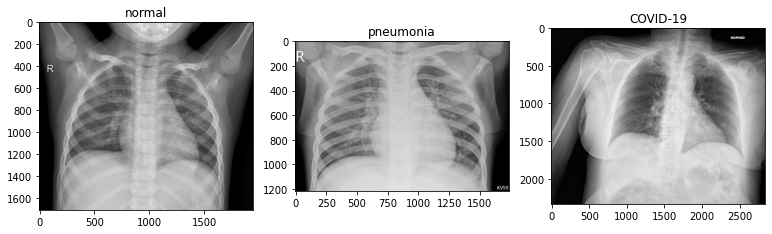

In [6]:
#Plot some examples of the dataset
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(13,4))
ax1.imshow(image_normal,cmap='gray')
ax1.set_title('normal' )
ax2.imshow(image_pneumonia,cmap='gray')
ax2.set_title('pneumonia')
ax3.imshow(image_covid,cmap='gray')
ax3.set_title('COVID-19')


NOTE: the size of the images is homogenized in the generator

## Explore the Dataset

In [7]:
num_images_test,covid_test,normal_test,pneumonia_test=count(dir_test)
num_images_train,covid_train,normal_train,pneumonia_train=count(dir_train)
num_images_validation,covid_validation,normal_validation,pneumonia_validation=count(dir_validation)

print('training images: {}'.format(num_images_train))
print('validation images: {}'.format(num_images_validation))
print('test images: {}'.format(num_images_test))


training images: 3860
validation images: 1287
test images: 1285


Text(0.5, 1.0, 'Images in the Dataset')

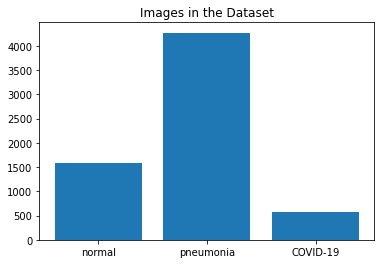

In [8]:
images_covid=covid_train+covid_test+covid_validation
images_normal=normal_train+normal_test+normal_validation
images_pneumonia=pneumonia_train+pneumonia_test+pneumonia_validation
labels=["normal","pneumonia","COVID-19"]
plt.bar(labels,[images_normal,images_pneumonia,images_covid])
plt.title("Images in the Dataset")

Unbalanced data: As seen in the figure, the data is unbalanced. There are significantly fewer images with COVID-19 compared to the other classes.

Solution: Weight the loss function with class weights, so that the model considers that there is a class that is underrepresented and balances the loss.

Weights to Balance the Dataset

In [9]:
# Scaling by (total / 3) helps keep the loss at a similar magnitude.
total=images_covid+images_normal+images_pneumonia
weight_covid=(total/3)*(1/images_covid)
weight_pneumonia=(total/3)*(1/images_pneumonia)
weight_normal=(total/3)*(1/images_normal)


In [10]:
#dictionary with weights to use later in training
dict_weights={0:weight_covid,1:weight_normal,2:weight_pneumonia}

## Prepare data for training

Keras ImageDataGenerator is used to generate batches of images from image directory

In [11]:
#Generator for training images
generator_train=tf.keras.preprocessing.image.ImageDataGenerator()
train_data_gen=generator_train.flow_from_directory( dir_train,target_size=(256,256),batch_size=32,shuffle=True )

Found 3860 images belonging to 3 classes.


In [12]:
#Generator for test images
generator_test=tf.keras.preprocessing.image.ImageDataGenerator()
test_data_gen=generator_test.flow_from_directory(dir_test,target_size=(256,256),batch_size=32,shuffle=True )

Found 1285 images belonging to 3 classes.


In [13]:
#Generator for validation images
generator_validation=tf.keras.preprocessing.image.ImageDataGenerator()
val_data_gen=generator_validation.flow_from_directory(dir_validation,target_size=(256,256),batch_size=32,shuffle=True )

Found 1287 images belonging to 3 classes.


shape of batch:  (32, 256, 256, 3)


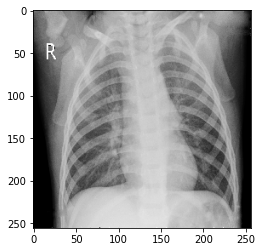

In [14]:
#Generated batch form and display an image of that batch
l=(next(train_data_gen)[0])/255.0
print('shape of batch: ',l.shape)
plt.imshow( np.squeeze(l)[0])

In [15]:
#respective classes and indices
train_data_gen.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

## Creation of the model

### Load Resnet50  

A Resnet50 will be used as the base model

In [16]:
resnet50=tf.keras.applications.ResNet50( include_top=False,input_shape=(256,256,3) ,weights=None   )

In [17]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

run the next cell if you want to draw the model and save it in 'png' format

In [18]:
#plot_model( resnet50,show_shapes=True,to_file='model/base_model.png')

In [19]:
#Number of layers in Resnet50
n_layers_resnet=len(resnet50.layers)
print('Number of layers',n_layers_resnet)

Number of layers 175


In [20]:
resnet50.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

### CovidResnet construction
Assembling the custom layers for the covid detection task to the Resnet50 base model

In [21]:
covid_resnet=create_covidResnet(resnet50)

In [22]:
covid_resnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              839270

In [23]:
#Number of total CovidResnet layers
print('Number of total CovidResnet layers:',len(covid_resnet.layers)+n_layers_resnet-1)

Number of total CovidResnet layers: 183


### Prepare Callbacks


In [24]:
checkpoints_dir='model/checkpoints'

In [25]:
#create checkpoint
path_ckpt_train='training/cp-{epoch:04d}.ckpt'
dir_ckpt_train=os.path.dirname(path_ckpt_train)
checkpoint,dir_ckpt=create_checkpoint(path_ckpt_train,checkpoints_dir)

In [26]:
#callback to reduce the learning rate when the loss in the validation set stagnates
lr_reduce=tf.keras.callbacks.ReduceLROnPlateau(factor=0.7,patience=3  )

In [27]:
#custom callback to store the most relevant metrics 
#on unbalanced data problems
class Metrics(tf.keras.callbacks.Callback):

  def __init__(self,generator,validation_set=True):
    super(Metrics,self).__init__()
    self.gen=generator
    self.validation_set=validation_set
    
  
  def on_train_begin(self,logs={}):
    self.metrics={'precision':[],'recall':[],'f1_score':[],'ind_max_f1':0}
    self.x,self.y,self.class_indices=total_batch(self.gen)
    

  def on_epoch_end(self,epoch, logs={}):
    labels=list(self.class_indices.values())
    y_score=self.model.predict(self.x)
    y_pred=np.argmax(y_score,axis=-1)
    precision=precision_score(self.y, y_pred, average=None ,labels=labels, zero_division=0)
    recall=recall_score(self.y, y_pred, average=None, labels=labels)
    f1=f1_score(self.y, y_pred,average='macro', labels=labels)

    self.metrics['precision'].append(list(precision))
    self.metrics['recall'].append(list(recall))
    self.metrics['f1_score'].append(f1)
    
    if self.validation_set:
      print(' - val_precision: {} - val_recall: {}'.format(precision,recall))
    else:
      print('- precision: {} - recall: {}'.format(precision,recall))
  
  def on_train_end(self,logs={}):
    self.metrics['ind_max_f1']=np.argmax(np.array(self.metrics['f1_score']))


    


In [28]:
metrics=Metrics(val_data_gen)

### Compile model

In [29]:
learning_rate=0.001
#instantiate Adam optimizer
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

#compile model for training
covid_resnet.compile( optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Train CovidResnet

In [30]:
history=covid_resnet.fit( x=train_data_gen,validation_data=val_data_gen,epochs=30,callbacks=[lr_reduce,checkpoint,metrics],class_weight=dict_weights)

Epoch 1/30
121/121 [==============================] - 132s 1s/step - loss: 3.5148 - accuracy: 0.4024 - val_loss: 1.3800 - val_accuracy: 0.3225
 - val_precision: [0.12419974 0.         0.63346614] - val_recall: [0.84347826 0.         0.37192982]
Epoch 2/30
121/121 [==============================] - 121s 1s/step - loss: 0.5997 - accuracy: 0.6833 - val_loss: 1.4088 - val_accuracy: 0.6239
 - val_precision: [0.3125     0.         0.72024415] - val_recall: [0.82608696 0.         0.82807018]
Epoch 3/30
121/121 [==============================] - 121s 993ms/step - loss: 0.4356 - accuracy: 0.7834 - val_loss: 0.6259 - val_accuracy: 0.7700
 - val_precision: [0.5320197  0.74747475 0.82957111] - val_recall: [0.93913043 0.46687697 0.85964912]
Epoch 4/30
121/121 [==============================] - 122s 1s/step - loss: 0.3574 - accuracy: 0.8375 - val_loss: 0.5279 - val_accuracy: 0.8081
 - val_precision: [0.5045045  0.8490566  0.87690504] - val_recall: [0.97391304 0.56782334 0.8748538 ]
Epoch 5/30
121/12

Notes:
*  val_precision and val_recall (precision and sensitivity or recall) show the metrics for each class in the following order: [covid - normal- pneumonia]
* Running the first epoch could take significantly longer than the later ones due to internal Tensorflow processes that you have to perform as the images have different sizes.You can read more about this at : https://github.com/tensorflow/tensorflow/issues/13114


## Plot metrics

In [31]:
history_dir='model/history'

In [32]:
#save history on disk to be able to be loaded and plotted without having to retrain the model
with open(history_dir,'wb') as file:
  pickle.dump(history.history,file)


In [33]:
#open training history from disk
hist=pickle.load(open(history_dir,'rb'))

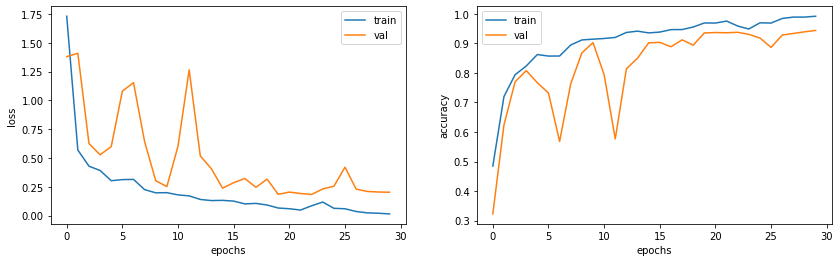

In [34]:
plot_history(hist)

In [35]:
metrics_dir='model/metrics'

In [36]:
#save metrics on disk so that they can be loaded and graphed without the need to retrain the model
with open(metrics_dir,'wb') as file:
  pickle.dump(metrics.metrics,file)

In [37]:
#open training metrics from disk
metrics_restored=pickle.load(open(metrics_dir,'rb'))

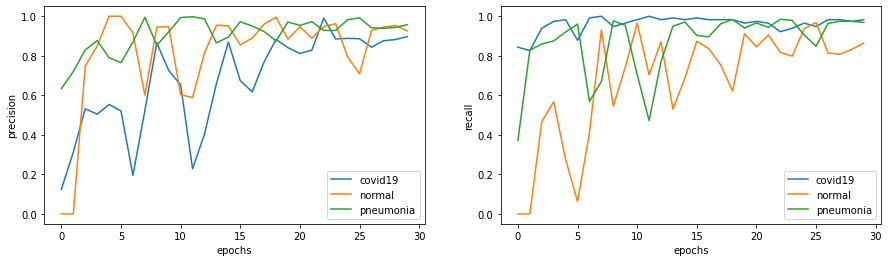

In [38]:
plot_metrics(metrics_restored)

### Restore model

In [39]:
#index of the best model saved according to the metric f1-score
ind_best_model=metrics_restored['ind_max_f1']

In [40]:
checkpoint_dir=os.path.join(checkpoints_dir,dir_ckpt_train)
best_ckpt=os.path.join(checkpoint_dir,'cp-{:04d}.ckpt'.format(ind_best_model+1))
print('best model in: {}'.format(best_ckpt))

best model in: model/checkpoints/training/cp-0030.ckpt


In [41]:
#create new model instance
covid_resnet_restored=create_covidResnet(resnet50)

In [42]:
#compile the new model
covid_resnet_restored.compile( optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
#Loads the weights
covid_resnet_restored.load_weights(best_ckpt)

In [44]:
covid_resnet_restored.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              8392

## Testing

In [45]:
test_loss=covid_resnet_restored.evaluate(test_data_gen,callbacks=[metrics])

41/41 [==============================] - 35s 831ms/step - loss: 0.2184 - accuracy: 0.9517


### Confusion Matrix

In [46]:
x_test,y_test,class_ind_test=total_batch(test_data_gen)

In [47]:
y_pred_test=np.argmax(covid_resnet_restored.predict(x_test),axis=1)

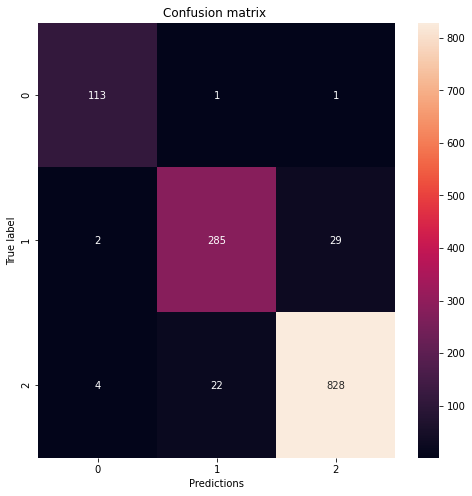

In [48]:
plot_confusion_matrix(y_test,y_pred_test,labels=[0,1,2])

In [49]:
print(classification_report( y_test,y_pred_test, target_names=["covid-19","normal",'pneumonia']))

              precision    recall  f1-score   support

    covid-19       0.95      0.98      0.97       115
      normal       0.93      0.90      0.91       316
   pneumonia       0.97      0.97      0.97       854

    accuracy                           0.95      1285
   macro avg       0.95      0.95      0.95      1285
weighted avg       0.95      0.95      0.95      1285



## Conclusions
CovidResnet was created with the aim of detecting COVID-19 in frontal chest radiographs and the following results were achieved:
* Accuracy of the model in the test set --->95.17%
* Precision of the model for COVID-19 detection in test set--->95%
* Sensitivity or Recall of the model for COVID-19 detection in the test set --->98%
* F1-Score of the model for COVID-19 detection in the test set --->0.97



## ¡IMPORTANT! :
The CovidResnet model was created for research purposes only and is not ready for use in production, in no way should it be used to diagnose COVID-19, the diagnosis must be given by a qualified physician.